#**Advanced Lane Finding Project**
The goals / steps of this project are the following:
###Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
###Apply a distortion correction to raw images.
###Use color transforms, gradients, etc., to create a thresholded binary image.
###Apply a perspective transform to rectify binary image ("birds-eye view").
###Detect lane pixels and fit to find the lane boundary.
###Determine the curvature of the lane and vehicle position with respect to center.
###Warp the detected lane boundaries back onto the original image.
###Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle
    position.

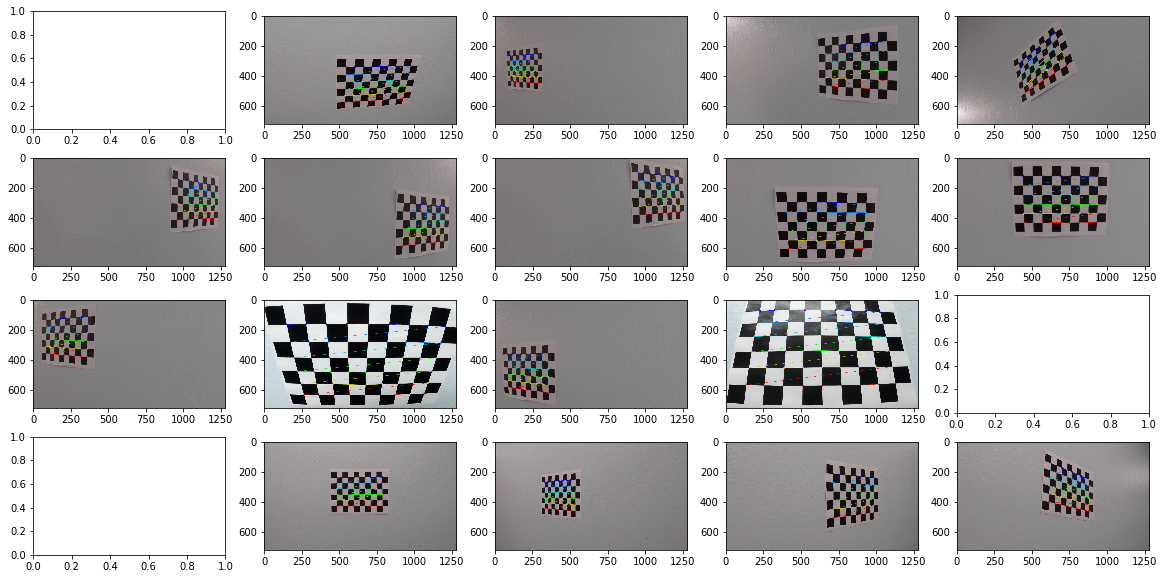

In [241]:
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.


# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

#Create a grid view 
figure, oslx = plt.subplots(4,5, figsize=(20, 10))
oslx = oslx.ravel()

# Step through the list and search for chessboard corners

for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw  the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Store all found images in "images_found" folder
        write_name = 'images_found/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)
        #Display the corners
        oslx[idx].imshow(img)
        idx=idx+1
        

#Some images might didn't find.
def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


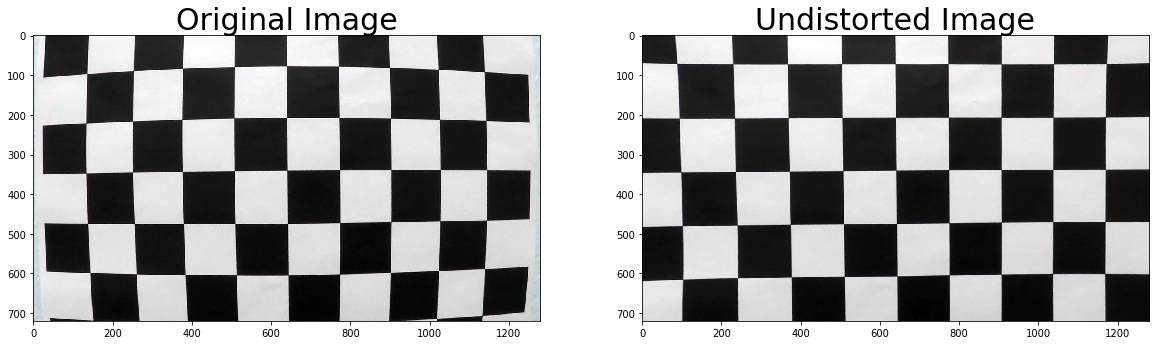

In [242]:
import pickle

# Test undistortion on an image
test_img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)


dst = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite('images_found/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "images_found/dist_pickle.p", "wb" ) )
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

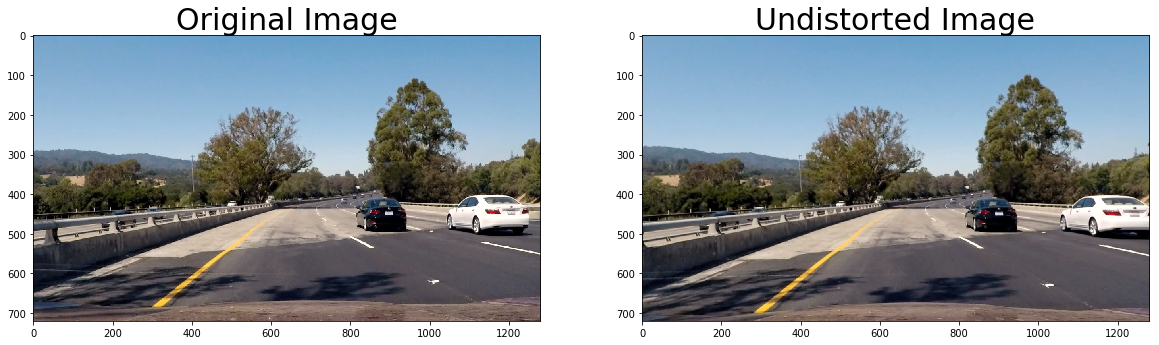

In [243]:
import pickle
import matplotlib.image as mpimg

# Test undistortion on raw image
test_raw_img = mpimg.imread('test_images/test4.jpg')
img_size = (img.shape[1], img.shape[0])

def cal_undistort(img, objpoints, imgpoints):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist


undist_raw = cal_undistort(test_raw_img, objpoints, imgpoints)
cv2.imwrite('output_images/test_raw_undist.jpg',undist_raw)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_raw_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undist_raw)
ax2.set_title('Undistorted Image', fontsize=30)

True

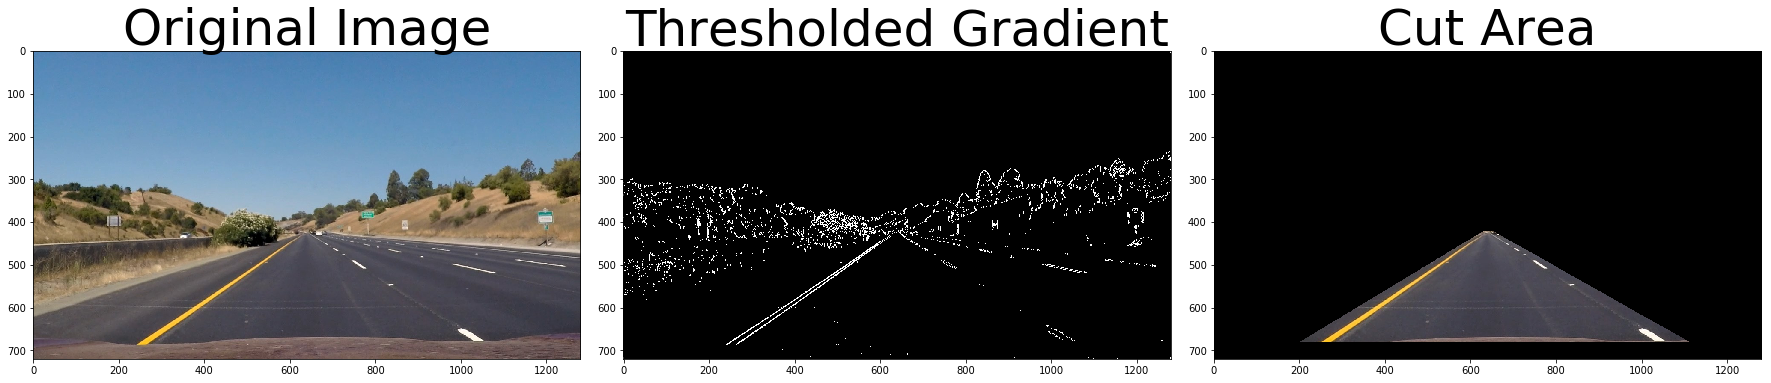

In [244]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

# Read in an image and grayscale it
img = mpimg.imread('test_images/straight_lines1.jpg')
#Cut the interested area
def region_of_interest(img):
    ysize = img.shape[0]
    xsize = img.shape[1]
    
    vertices = np.array([[(200,ysize-40), 
                          (630,420),
                          (650,420),
                          (xsize-170,ysize-40) ]] ,dtype = np.int32)
  
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    #plt.imshow(sxbinary, cmap='gray')
    return binary_output


grad_binary = abs_sobel_thresh(img, orient='x', thresh_min=30, thresh_max=100)
cut_image= region_of_interest(img)

# Plot the result
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
ax3.imshow(cut_image)
ax3.set_title('Cut Area', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

cv2.imwrite('output_images/thresholded_gradient.jpg',grad_binary)
cv2.imwrite('output_images/cut_area.jpg',cut_image)


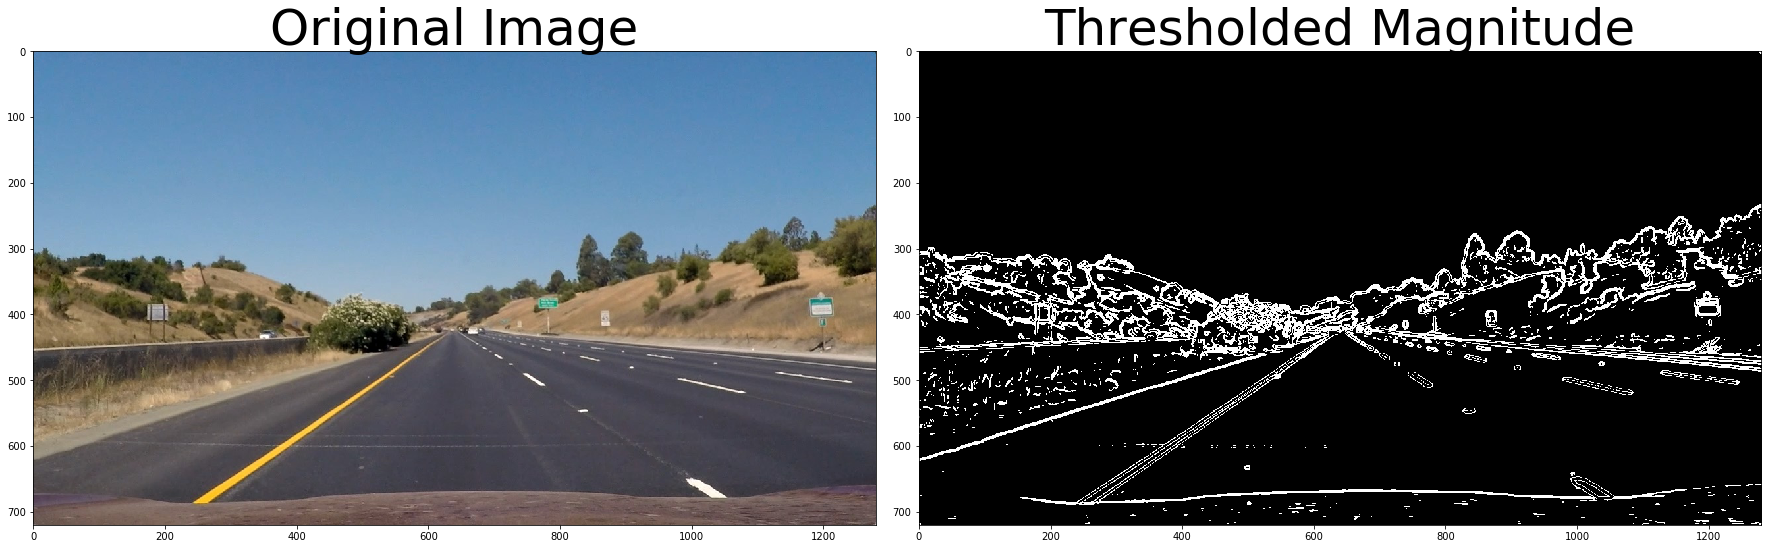

In [245]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

 # Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(image, sobel_kernel=9, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output   
    
# Run the function
mag_binary = mag_thresh(image, sobel_kernel=9, mag_thresh=(30, 100))
cv2.imwrite('output_images/thresholded_magnitude.jpg',mag_binary)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

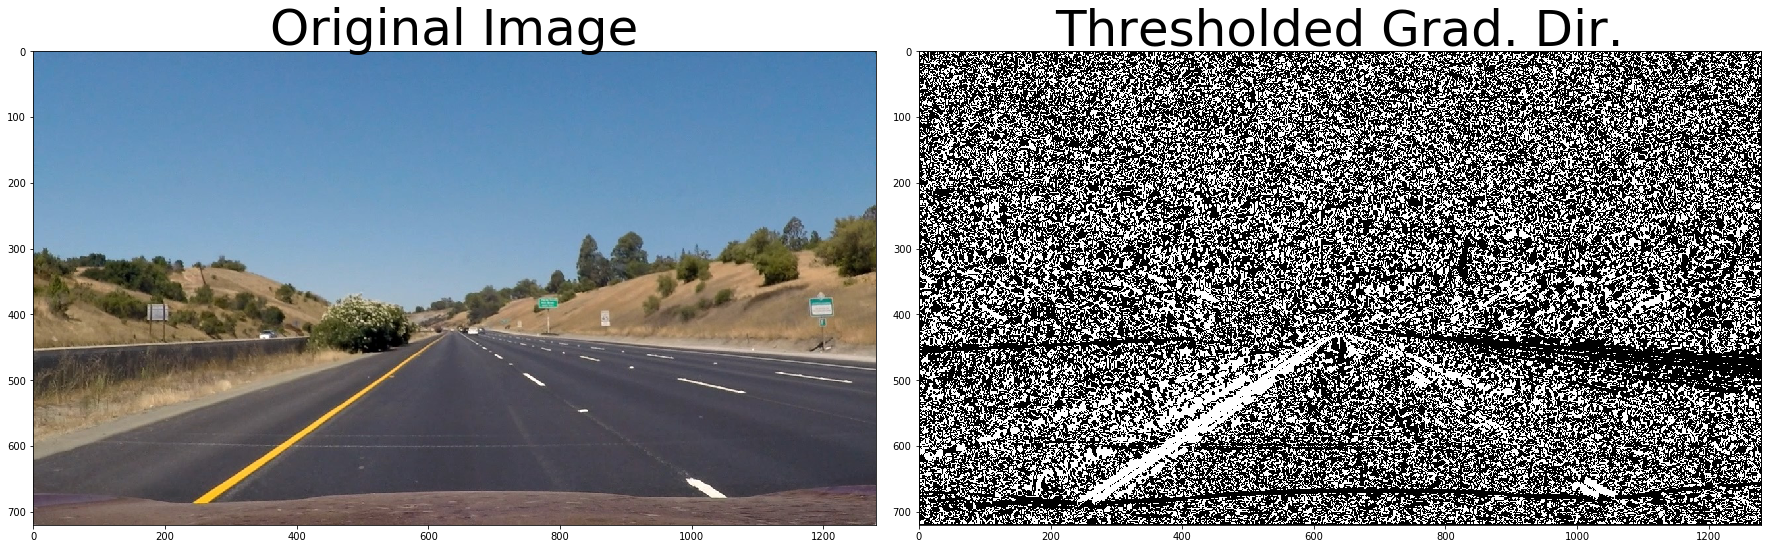

In [246]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle


# Read in an image
image = mpimg.imread('test_images/straight_lines1.jpg')

# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output
    
# Run the function
dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))
cv2.imwrite('output_images/thresholded_grad_dir.jpg',dir_binary)


# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


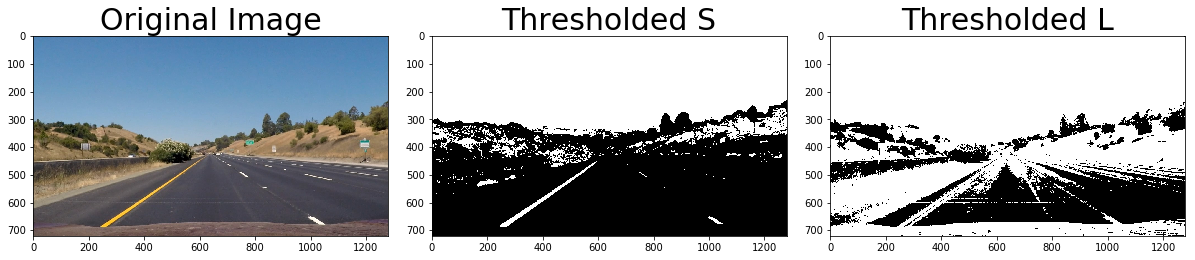

In [247]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

# Read in an image, you can also try test1.jpg or test4.jpg
image = mpimg.imread('test_images/straight_lines1.jpg')

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)

def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output
def hls_l(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    binary_output = np.zeros_like(l_channel)
    binary_output[(l_channel > thresh[0]) & (l_channel <= thresh[1])] = 1
    return binary_output
    
hls_binary = hls_select(image, thresh=(80, 255))
hls_binary1 = hls_l(image, thresh=(80, 255))
cv2.imwrite('output_images/thresholded_S.jpg',hls_binary)
cv2.imwrite('output_images/thresholded_L.jpg',hls_binary1)

# Plot the result
f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(16, 7))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(hls_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=30)
ax3.imshow(hls_binary1, cmap='gray')
ax3.set_title('Thresholded L', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

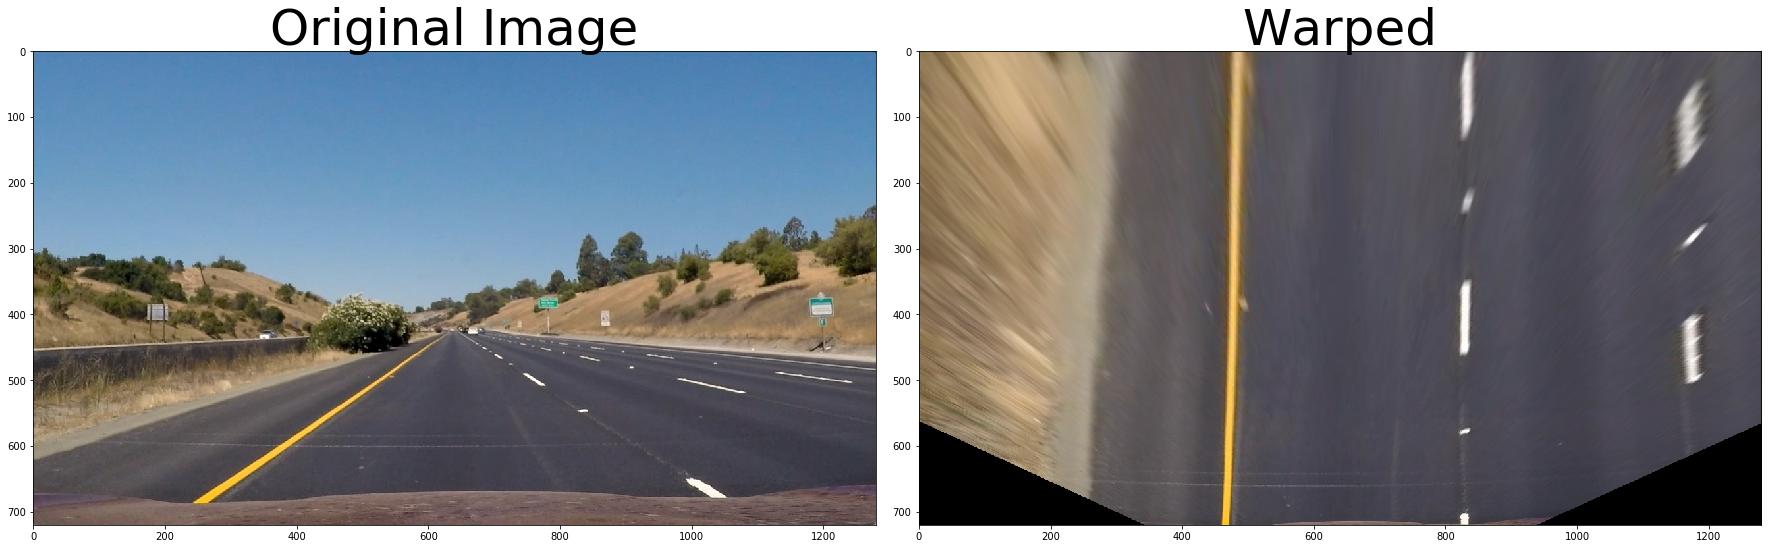

In [250]:
# Perspective Transform image result

def unwarp(img):
    img_size = (img.shape[1], img.shape[0])
    height,weight= img.shape[:2]
    
    #I took a lesson images. 
    #And under the assumption that the road is flat and 
    #the camera perspective hasn't changed   
    
    src = np.float32([(570,460),(700,460),(230,680), (1050,680)])
    dst = np.float32([(450,0),(weight-450,0),(450,height),(weight-450,height)])  
     #   the transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)
    #   warp image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)  
    return warped, M, M_inv

image = mpimg.imread('test_images/straight_lines1.jpg')

warped,M,M_inv = unwarp(image)
cv2.imwrite('output_images/warped.jpg',warped) 
# Store warped images in "images_found" folder
write_name = 'images_found/warped_ex.jpg'
cv2.imwrite(write_name, warped)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Warped', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

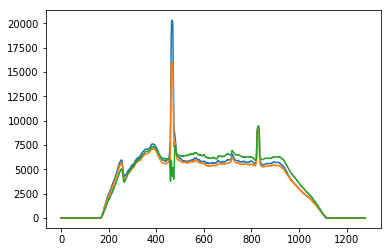

In [251]:
import numpy as np
img=warped
histogram = np.sum(img[img.shape[1]//2:,:], axis=0)
plt.plot(histogram)

In [252]:
def slidingwindow(binary_warped):    
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    #plt.imshow(img)
    #print("In LR fit")
    global left_fitx_prev, right_fitx_prev, left_fity_prev, right_fity_prev
    histogram = np.sum(binary_warped[int(binary_warped.shape[1]//2):,:], axis=0)
    #plt.plot(histogram)
    #plt.xlim(0, 1280)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 90
    # Set minimum number of pixels found to recenter window
    minpix = 45
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    #implement global variables
    
    # Fit a second order polynomial to each
    if len(leftx) != 0:  # To avoid non-empty vector for x
        left_fit = np.polyfit(lefty, leftx, 2)
        left_fitx_prev = left_fit
        left_fity_prev = lefty
    else:
        left_fit = left_fitx_prev
        lefty = left_fity_prev
    
    if len(rightx) != 0: # To avoid non-empty vector for x
        right_fit = np.polyfit(righty, rightx, 2)
        right_fitx_prev = right_fit
        right_fity_prev = righty
    else:
        right_fit = right_fitx_prev
        righty = right_fity_prev
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]   
    return out_img, ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, histogram

def draw_lines(img, warped, ploty, left_fitx, right_fitx, M_inv):
    # Create an image to draw the lines on
    undist=img
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    lanes=cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    """
    #plt.imshow(result)
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(undist)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(result)
    ax2.set_title('Lane Lines', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    """
    return result

In [237]:
def radius_curv(bin_img, ploty, leftx, rightx, lefty, righty):
    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y
    global left_curverad_prev, right_curverad_prev
    y_eval = np.max(ploty)
     
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/640 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    if len(leftx)==0 or len(lefty)==0 or len(rightx)==0 or len(righty)==0:
        leftx = left_fitx_prev
        if len(lefty)==0:
            lefty = left_fity_prev
        if len(rightx)==0:
            rightx = right_fitx_prev
        if len(righty)==0:    
            righty = right_fity_prev
        return left_curverad_prev, right_curverad_prev
        
    else:    
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
            # Calculate the new radii of curvature
        if len(rightx)==0:    
            rightx = right_fit_prev

        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        left_curverad_prev = left_curverad
        right_curverad_prev = right_curverad
    return left_curverad, right_curverad

def dist_from_center(histogram):
    xm_per_pix = 3.7/700
    midpoint = np.int(histogram.shape[0]/2)
    left_x_point = np.argmax(histogram[:midpoint])
    right_x_point = np.argmax(histogram[midpoint:]) + midpoint
    screen_off_center = midpoint - (int(left_x_point + right_x_point)/2)
    meters_off_center = xm_per_pix * screen_off_center
    return meters_off_center
                     
def write_details(undist_img,lane_img, pos_off, rad):
    org_img = undist_img
    fin_img = lane_img    
    font = cv2.FONT_HERSHEY_PLAIN
    radius = "Radius of Curvature: {} m".format(int(rad))
    cv2.putText(fin_img,radius,(50,100), font, 1.8,(255,255,255),2)
    text = "{:.2f} m off center".format(pos_off)
    cv2.putText(fin_img,text,(50,160), font, 1.8,(255,255,255),2)  
    return fin_img

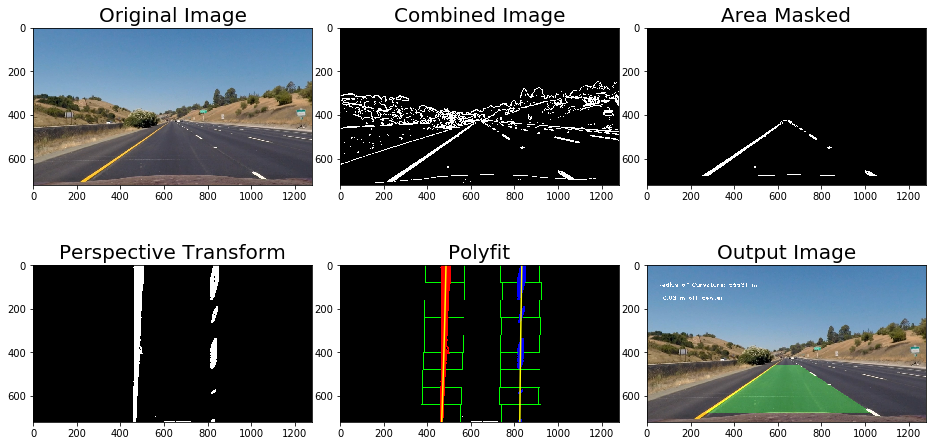

In [253]:
def pipeline(img, ksize=3):
    
    #Run this Pipeline to test all methods
            
    # Undistort image
    undistorted_test = cal_undistort(img, objpoints, imgpoints)
    
    # Sobel Operator (X or Y Gradient)    
    gradx = abs_sobel_thresh(undistorted_test, orient='x',  thresh_min=15,thresh_max=255)
    grady = abs_sobel_thresh(undistorted_test, orient='y',  thresh_min=30,thresh_max=255)

    # Sobel Magnitude of Gradient
    mag_binary = mag_thresh(undistorted_test,  mag_thresh=(40, 255))
    
    # Sobel Direction of Gradient
    dir_binary = dir_threshold(undistorted_test, sobel_kernel=ksize, thresh=(0, 0.09))

    # HLS Color Channel S - Channel
    s_channel = hls_select(undistorted_test, thresh=(120, 255))
    
    # HLS Color Channel S - Channel
    l_channel = hls_l(undistorted_test, thresh=(210, 255))
    
    # Combine X,Y,Mag gradient, and S - Channel
    combined = np.zeros_like(s_channel)
    combined[(s_channel == 1) | (mag_binary == 1)] = 1
    
    # Area of Interest Mask
    area_img = region_of_interest(combined)
    
    # Perspective Transform
    binary_warped, M, M_inv = unwarp(area_img)
    
    out_img, ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, histogram = slidingwindow(binary_warped)
    lane_img_test = draw_lines(undistorted_test, binary_warped, ploty, left_fitx, right_fitx, M_inv)
    left_curverad, right_curverad = radius_curv(binary_warped, ploty, leftx, rightx, lefty, righty)
    pos_off = dist_from_center(histogram)

    result_test = write_details(undistorted_test, lane_img_test, pos_off, (left_curverad + right_curverad)/2)
      
    
    fig, axs = plt.subplots(2,3, figsize=(16, 8))
    fig.subplots_adjust(hspace = .2, wspace=.1)
    axs = axs.ravel()
    axs[0].imshow(undistorted_test)
    axs[0].set_title('Original Image', fontsize=20)
    axs[1].imshow(combined, cmap='gray')
    axs[1].set_title('Combined Image', fontsize=20)
    axs[2].imshow(area_img, cmap='gray')
    axs[2].set_title('Area Masked', fontsize=20)
    axs[3].imshow(binary_warped, cmap='gray')
    axs[3].set_title('Perspective Transform', fontsize=20)
    axs[4].imshow(out_img)
    axs[4].plot(left_fitx, ploty, color='yellow')
    axs[4].plot(right_fitx, ploty, color='yellow')
    axs[4].set_title('Polyfit', fontsize=20)
    axs[5].imshow(result_test)
    axs[5].set_title('Output Image', fontsize=20)
    
# Demo All Functions
ksize=5 # Setting Kernel Size
test_image = cv2.imread('test_images/straight_lines1.jpg')
pipeline(image, ksize=5)


In [249]:

def pipeline_for_video(img, ksize=5):            
           
    
    #Pipeline for video
            
    # Undistort image
    undistorted_test = cal_undistort(img, objpoints, imgpoints)
    
    # Sobel Magnitude of Gradient
    #mag_binary = mag_thresh(undistorted_test, sobel_kernel=ksize, mag_thresh=(40, 255))
    
    # HLS Color Channel S - Channel
    s_channel = hls_select(undistorted_test, thresh=(100, 255))
    
    # HLS Color Channel S - Channel
    l_channel = hls_l(undistorted_test, thresh=(200, 255))
    
    # Combine Mag gradient, S - Channel, and L - Channel
    combined1 = np.zeros_like(s_channel)
    combined1[(s_channel == 1)  | (mag_binary == 1)] = 1
     
    # Area of Interest Mask
    area_img = region_of_interest(combined1)
    
    # Perspective Transform
    binary_warped, M, M_inv = unwarp(area_img)
    
    return undistorted_test, binary_warped, M, M_inv

def process_test():# Reading all images in /test_images folder

    images_test = glob.glob('./test_images/*.jpg')
    ksize=5 # Setting Kernel Size
    for fname1 in images_test:
        img_t = cv2.imread(fname1)
        undist, bin_img, M, M_inv = pipeline_for_video(img_t, ksize)    
#Plot the Result
        out_img,ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist = slidingwindow(bin_img)
        lane_img = draw_lines(undist, bin_img, ploty, left_fitx, right_fitx, M_inv)
        left_curverad, right_curverad = radius_curv(bin_img, ploty, leftx, rightx, lefty, righty)
        pos_off = dist_from_center(hist)
        result = write_details(undist, lane_img, pos_off, (left_curverad + right_curverad)/2)
    

In [240]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

def video_process(img):
    global i, ploty_p, left_fitx_p, right_fitx_p, leftx_p, rightx_p, lefty_p, righty_p, hist_p
    global ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi
    
    
    ksize=3
    img_t = img
    offset = 900
    undist, bin_img, M, M_inv = pipeline_for_video(img_t, ksize)    
    #Plot the Result
    out, ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist = slidingwindow(bin_img)
    left_curverad, right_curverad = radius_curv(bin_img, ploty, leftx, rightx, lefty, righty)
    pos_off = dist_from_center(hist)
   # ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi= ploty_p, left_fitx_p, right_fitx_p, leftx_p, rightx_p, lefty_p, righty_p, hist_p
    if int((left_curverad + right_curverad)/2) > 800:
        ploty_p, left_fitx_p, right_fitx_p, leftx_p, rightx_p, lefty_p, righty_p, hist_p = ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist
        lane_img = draw_lines(undist, bin_img, ploty, left_fitx, right_fitx, M_inv)
        #result = write_details(undist, lane_img, pos_off, (left_curverad + right_curverad)/2) 
        i = i+1
        if (i-offset > 100):
            ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi = ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist
    elif int((left_curverad + right_curverad)/2) < 800:
        ploty, left_fitx, right_fitx, leftx, rightx, lefty, righty, hist = ploty_pi, left_fitx_pi, right_fitx_pi, leftx_pi, rightx_pi, lefty_pi, righty_pi, hist_pi
        lane_img = draw_lines(undist, bin_img, ploty, left_fitx, right_fitx, M_inv)
        #result = write_details(undist, lane_img, pos_off, (left_curverad + right_curverad)/2) 

    return lane_img

In [227]:
my_output = 'output_images/project_output.mp4'
clip2 = VideoFileClip('project_video.mp4', audio=False)
my_clip = clip2.fl_image(video_process)
%time my_clip.write_videofile(my_output,fps=10, audio=False)


[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4



 31%|███       | 155/505 [02:34<06:08,  1.05s/it]


 61%|██████    | 309/505 [05:08<03:31,  1.08s/it]


 92%|█████████▏| 463/505 [07:43<00:45,  1.08s/it]


100%|█████████▉| 504/505 [08:24<00:00,  1.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 8min 26s, sys: 3.08 s, total: 8min 29s
Wall time: 8min 27s
